In [3]:
from brian import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pylab
%matplotlib inline

Vt = -50 * mV          # spike threshold
Vr = -60 * mV          # reset value
refr_period = 5*ms # absolute refractory period

tau_e = 15*ms # membrane time constant (for excitatory synapses)
tau_i = 10*ms # membrane time constant (for inhibitory synapses)
tau_syn_2_e = 3*ms # exc synaptic time constant tau2 in paper
tau_syn_2_i = 2*ms # inh synaptic time constant tau2 in paper
tau_syn_1 = 1*ms # exc/inh synaptic time constant tau1 in paper

clear(True, True) 
reinit()# To reinit BRIAN clocks and remove all old BRIAN objects from namespace,
# it's usually a good idea to put this at the beginning of a script

eqs = Equations('''
        dV/dt  = (ge-gi-(V-mu))/taum : volt
        dge/dt = -ge/tau_syn_1       : volt
        dgi/dt = -gi/tau_syn_2       : volt
        taum : ms
        tau_syn_2 : ms
        mu : volt
        ''')

/Users/Jan/.virtualenvs/research/lib/python2.7/site-packages/brian/utils/sparse_patch/__init__.py:39: UserWarning: Couldn't find matching sparse matrix patch for scipy version 0.15.1, but in most cases this shouldn't be a problem.
  warnings.warn("Couldn't find matching sparse matrix patch for scipy version %s, but in most cases this shouldn't be a problem." % scipy.__version__)


In [4]:
# Set up Neuron Groups and parameters
N_e = 4000
N_i = 1000

# bias 
mu_e = Vt + np.random.uniform(1.1, 1.2, N_e) * (Vt-Vr) # bias for excitatory neurons
mu_i = Vt + np.random.uniform(1.0, 1.05, N_i) * (Vt-Vr) # bias for excitatory neurons

# Let's create 5000 neurons
G = NeuronGroup(N=N_e+N_i,
                model=eqs,
                threshold=Vt,
                reset=Vr,
                refractory=refr_period,
                freeze = True,
                method='Euler',
                compile=True)

# Excitatory neurons, set parameters per population
Ge = G.subgroup(N_e) 
Ge.taum = tau_e
Ge.tau_syn_2 = tau_syn_2_e
Ge.mu = mu_e
# Inhibitory neurons
Gi = G.subgroup(N_i)  
Gi.taum = tau_i
Gi.tau_syn_2 = tau_syn_2_i
Gi.mu = mu_i

In [40]:
# Set up connections
# Connection probability, on average
conn_prob_ee = 0.2
conn_prob_ii = 0.5
conn_prob_ei = 0.5
conn_prob_ie = 0.5

# Cluster coefficient 
R_ee = 2.5
# connection probs for clusters
p_in, p_out = determine_cluster_conn(R_ee)

# use absolute weights because inhibitory influence is given by sign of y above
wee = 0.024 *mV
wei = 0.045 *mV
wii = 0.057 *mV
wie = 0.014 *mV

Cee = Connection(Ge, Ge, 'ge', sparseness=conn_prob_ee, weight=wee)
Cei = Connection(Ge, Gi, 'ge', sparseness=conn_prob_ei, weight=wei)
Cie = Connection(Gi, Ge, 'gi', sparseness=conn_prob_ie, weight=wie)
Cii = Connection(Gi, Gi, 'gi', sparseness=conn_prob_ii, weight=wii)

In [43]:
M = SpikeMonitor(G)
MV = StateMonitor(G, 'V', record=0)
Mge = StateMonitor(G, 'ge', record=0)
Mgi = StateMonitor(G, 'gi', record=0)

In [44]:
G.V = Vr + (Vt - Vr) * rand(len(G))
run(500 * ms)

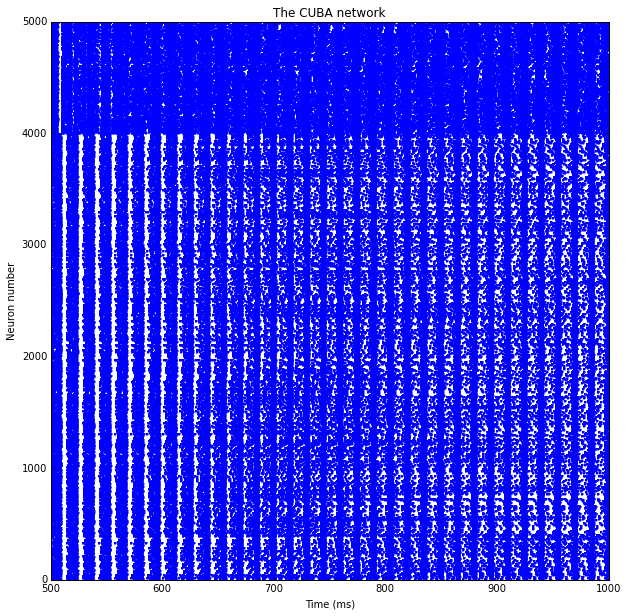

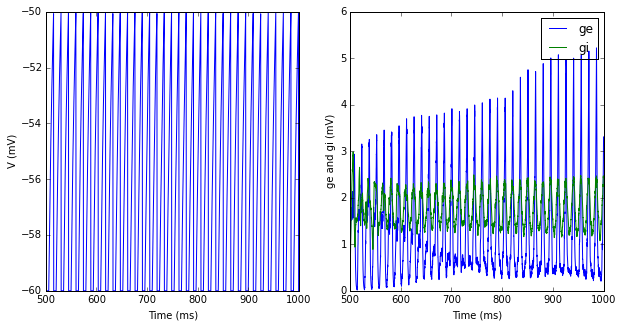

In [45]:
plt.figure(figsize=(10,10))
raster_plot(M, title='The CUBA network', newfigure=False)
plt.figure(figsize=(10,5))
plt.subplot(121)
plot(MV.times / ms, MV[0] / mV)
xlabel('Time (ms)')
ylabel('V (mV)')
subplot(122)
plot(Mge.times / ms, Mge[0] / mV)
plot(Mgi.times / ms, Mgi[0] / mV)
xlabel('Time (ms)')
ylabel('ge and gi (mV)')
legend(('ge', 'gi'), 'upper right')
show()